<a href="https://colab.research.google.com/github/Himanshu0518/NLP/blob/main/sentiment_analysis_on_IMDB_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d vishakhdapat/imdb-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews
License(s): MIT
 66% 17.0M/25.7M [00:00<00:00, 58.1MB/s]
100% 25.7M/25.7M [00:00<00:00, 63.7MB/s]


In [3]:
from zipfile import ZipFile
dataset = '/content/imdb-movie-reviews.zip'
with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv('/content/imdb-movie-reviews.zip')

In [6]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.columns = ['text','sentiments']

In [8]:
df.head()

,text,sentiments
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df.isnull().sum()

,0
text,0
sentiments,0


In [10]:
df.shape

(50000, 2)

In [11]:
df['sentiments'].value_counts()

,count
sentiments,
positive,25000
negative,25000


In [12]:
df.sentiments.value_counts()

,count
sentiments,
positive,25000
negative,25000


In [13]:
df['sentiments'] = df['sentiments'].replace({'positive':1,'negative':0})

In [14]:
df.head()

,text,sentiments
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [15]:
import nltk
from nltk.corpus import stopwords
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [17]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [18]:
def lemmatizing(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [lemmatizer.lemmatize(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [19]:
df['text'] = df['text'].apply(lemmatizing)

In [20]:
X = df['text'].values
Y = df['sentiments'].values

In [24]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Bidirectional

In [25]:
vocab_size = 5000

## One hot Representation

In [26]:
message = X.copy()

In [27]:
onehot_rep = [one_hot(words,vocab_size) for words in message]

In [28]:
print(message[0])

one reviewer mentioned watching oz episode hooked right exactly happened br br first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word br br called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away br br would say main appeal show due fact go show dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experie

In [36]:
sent_length = 30
embedded_docs = pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)

In [37]:
print(embedded_docs[0])
print(type(embedded_docs[0]))

[1852 1421 2456  221  869   33 1481 1673 4123 2866  361 1780 3322 4599
 3380 1534  361 4611 2316 2117 2119 3226 3197 4774 2054 1460 2456  560
 4438 4228]
<class 'numpy.ndarray'>


In [38]:
# Creating the model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(loss='binary_crossentropy' , optimizer = 'adam' , metrics =['accuracy'])

# Build the model by specifying the input shape
model.build((None, sent_length))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 30, 40)              │         200,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 40)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 313,001 (1.19 MB)

 Trainable params: 313,001 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
X_final = np.array(embedded_docs)
Y_final = np.array(Y)

In [40]:
train_data,test_data,train_label,test_label = train_test_split(X_final,Y_final,test_size=0.1,random_state = 4)

In [41]:
model_history = model.fit(train_data,train_label,validation_data=(test_data,test_label),epochs=3,batch_size=32)

Epoch 1/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 54ms/step - accuracy: 0.7239 - loss: 0.5310 - val_accuracy: 0.7924 - val_loss: 0.4417
Epoch 2/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 83s 55ms/step - accuracy: 0.8211 - loss: 0.3995 - val_accuracy: 0.7794 - val_loss: 0.4523
Epoch 3/3
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 80s 53ms/step - accuracy: 0.8424 - loss: 0.3623 - val_accuracy: 0.7886 - val_loss: 0.4434


In [42]:
y_pred = model.predict(test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


In [43]:
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
y_pred = np.where(y_pred >= 0.5,1,0)

In [45]:
accuracy_score(y_pred,test_label)

0.7886

In [49]:
confusion_matrix(y_pred,test_label)

array([[1988,  556],
       [ 501, 1955]])

In [51]:
# Access training and validation accuracy
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

# Access training and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']


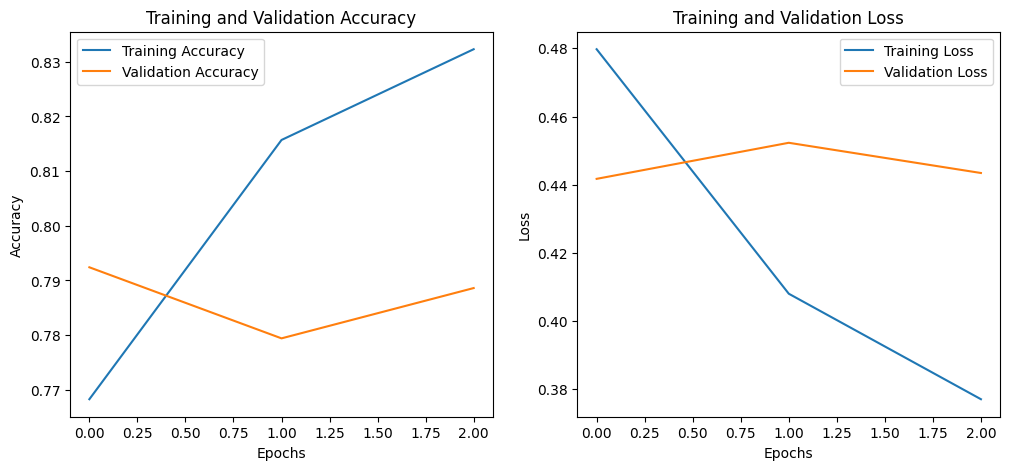

In [52]:

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [53]:
import pickle

In [54]:
config = {
    'vocab_size': vocab_size,
    'sent_length': sent_length,
    'word_index': {}  # If using a specific word index, save it here
}

In [55]:
with open('config_IMDB', 'wb') as f:
    pickle.dump(config, f)

In [56]:
model.save('IMDB_reviews_model.h5')